In [135]:
import os
import json
import torch
import textwrap
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from datasets import load_dataset  # Hugging Face Datasets
from transformers import AlbertTokenizer, AlbertModel, AlbertConfig

### Dataload & Params

In [136]:
# PARAMS
min_words = 300
max_words = 500
drop_diagonal = True
n_hidden_layers = 72
n_attention_heads = 1

# Create a directory to save the plots
date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = f"{date_time}_hl={n_hidden_layers}"
output_path = f"./plots/{folder_name}"
os.makedirs(output_path, exist_ok=True)

params = {
    "min_words": min_words,
    "max_words": max_words,
    "drop_diagonal": drop_diagonal,
    "n_hidden_layers": n_hidden_layers,
    "n_attention_heads": n_attention_heads,
}
with open(os.path.join(output_path, "params.json"), "w") as f:
    json.dump(params, f, indent=4)

In [137]:
# Load the WikiText-103 dataset (version 1)
wikitext = load_dataset("wikitext", "wikitext-103-v1")

# The WikiText language modeling dataset is a collection of over 100 million tokens
# extracted from the set of verified Good and Featured articles on Wikipedia

# Each example in the dataset is a complete Wikipedia article
# The articles are preprocessed and split into sections

### Define Model

In [138]:
al_tkz = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
# al_model = AlbertModel.from_pretrained("albert-xlarge-v2")

alm2_config = AlbertConfig.from_pretrained(
    "albert-xlarge-v2",
    num_hidden_layers=n_hidden_layers,
    num_attention_heads=n_attention_heads,
)
al_model = AlbertModel.from_pretrained("albert-xlarge-v2", config=alm2_config)

print("hidden layers: ", al_model.config.num_hidden_layers)
print("attention heads: ", al_model.config.num_attention_heads)

hidden layers:  72
attention heads:  1


### Random Input

In [139]:
def get_random_input(dataset, tokenizer, min_words=300, max_words=500):
    """
    Get a random input sequence from the dataset that meets minimum length requirements.

    dataset: HuggingFace dataset containing text data
    tokenizer: Tokenizer to convert text to model input format

    Q = why only use sequences longer than 300 tokens?
    A = because the model is large and the input sequence needs to be long enough to activate all the parameters

    Returns dictionary containing tokenized input with keys:
    - input_ids: Tensor of token IDs
    - token_type_ids: ???
    - attention_mask: Tensor of attention masks ( Q = why is this needed? )
    """
    n_train = len(dataset["train"])

    # # keep trying until we find a sequence longer than 300 tokens
    # while True:
    #     # random index in training data
    #     it = np.random.randint(n_train)
    #     print(f"trying {it}")
    #     text = dataset["train"][it]["text"]
    #     # tokenize with padding and truncation
    #     ei = tokenizer(text, return_tensors="pt", truncation=True)
    #     # termination condition
    #     if ei["input_ids"].shape[1] > 300:
    #         break

    start_idx = np.random.randint(n_train)
    collected_words = []
    word_count = 0

    for i in range(start_idx, n_train):
        new_words = dataset["train"][i]["text"].split()
        word_count += len(new_words)
        collected_words.extend(new_words)

        if word_count > max_words:
            # Drop the last chunk to stay within the limit
            collected_words = collected_words[: -len(new_words)]
            last_idx = i - 1
            break
        elif word_count > min_words:
            last_idx = i
            break

    text = " ".join(collected_words)
    ei = tokenizer(text, return_tensors="pt", truncation=True)
    return ei, start_idx, last_idx

In [140]:
ei, start_idx, last_idx = get_random_input(wikitext, al_tkz, min_words, max_words)

print("- " * 20)
print("Random Input:")
decoded_text = al_tkz.batch_decode(
    ei["input_ids"],
    # skip_special_tokens=True
)
wrapped_text = [textwrap.fill(t, width=100) for t in decoded_text]
print("\n\n".join(wrapped_text))
print("- " * 20)

- - - - - - - - - - - - - - - - - - - - 
Random Input:
[CLS] ss el oriente was a cargo ship built in 1910 for the morgan line , a subsidiary of the
southern pacific company . during world war i , she was known as uss el oriente ( id <unk>
-<unk><unk> ) in service with the united states navy . at the end of war , she reverted to her
original name of ss el oriente . during world war ii she was chartered by the international
committee of the red cross ( icrc ) as ss henri dunant ( sometimes also spelled henry dunant ) , but
reverted to her original name of ss el oriente at the end of the charter . ss el oriente was one of
four sister ships that carried cargo and a limited number of passengers for the morgan line . she
was acquired by the u.s. navy in july 1918 , and converted to carry horses and mules to france , and
after the armistice , was converted again to carry american troops home from europe . el oriente
returned to the morgan line in 1919 and sailed with them until june 1941 , wh

### Calc Corr

In [141]:
def compute_correlations(hidden_states, drop_diagonal=True):
    """
    Compute pairwise correlations between token representations for each layer's hidden states.

    hidden_states (list):
        List of tensors containing hidden states from each layer of the model.
        Each tensor has shape (batch_size=1, sequence_length, hidden_dim)

    Returns list of tensors containing flattened correlation matrices for each layer.
    Each tensor contains the pairwise correlations between all tokens in that layer.
    The correlations are computed as cosine similarities between normalized token representations.
    """
    corrs = []
    for hs in hidden_states:
        # Remove batch dimension and create a copy without gradient tracking
        T = hs.squeeze(0).clone().detach().requires_grad_(False)
        # Normalize each token's representation to unit length for cosine similarity
        T = torch.nn.functional.normalize(T, dim=1)
        # Compute pairwise cosine similarities between all tokens
        T2 = torch.matmul(T, T.transpose(0, 1))

        if drop_diagonal:
            mask = ~torch.eye(T2.size(0), dtype=bool, device=T2.device)
            sim_values = T2[mask].cpu().numpy()
        else:
            sim_values = T2.flatten().cpu().numpy()

        corrs.append(sim_values)
    return corrs

In [142]:
# get output features ... which contains last_hidden_state, pooler_output, hidden_states
# hidden_states is a list of tensors, each tensor has shape (batch_size=1, sequence_length, hidden_dim)
# last_hidden_state has shape (batch_size=1, sequence_length, hidden_dim)
# pooler_output has shape (batch_size=1, hidden_dim)

of = al_model(**ei, output_hidden_states=True)
correls = compute_correlations(of["hidden_states"], drop_diagonal=drop_diagonal)

### Plot Corr

In [143]:
# Save the input text as txt file in the folder
txt_fname = f"input_text_{start_idx}_{last_idx}"
with open(f"{output_path}/{txt_fname}.txt", "w") as f:
    f.write(decoded_text[0])

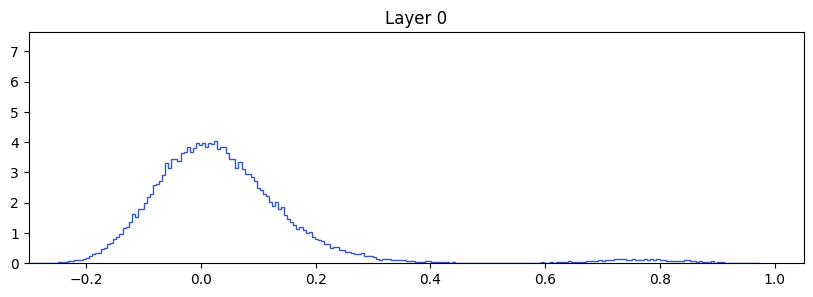

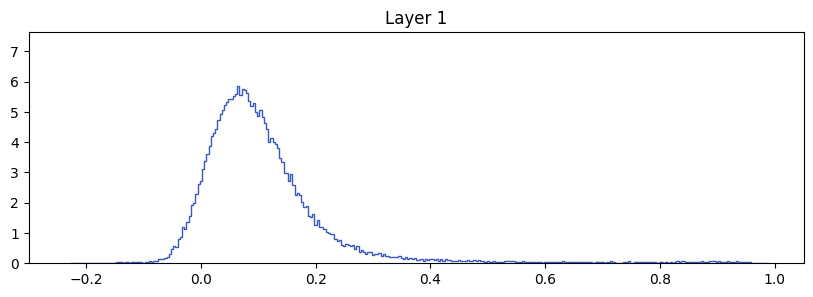

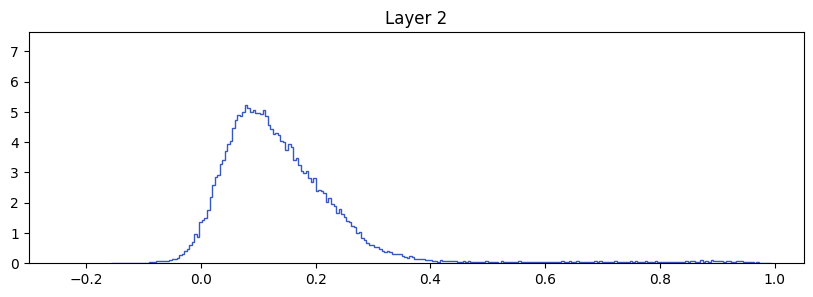

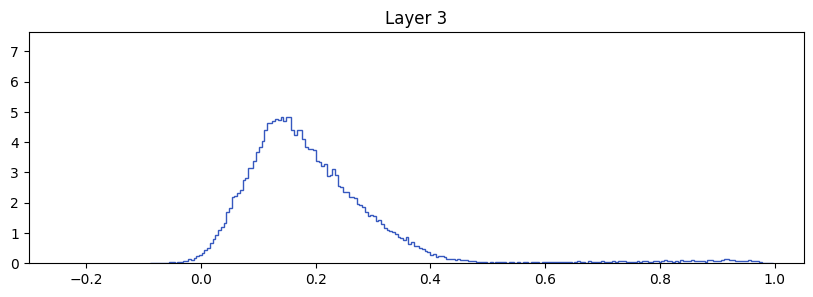

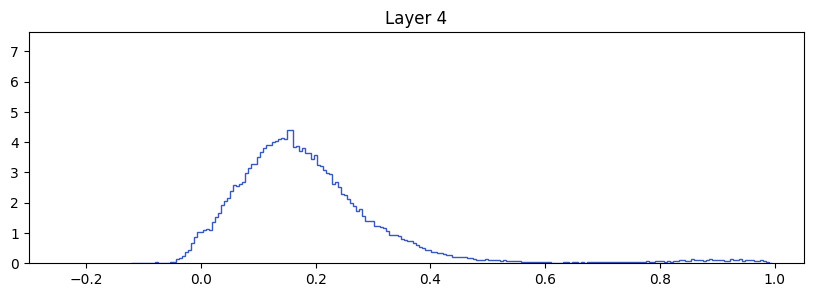

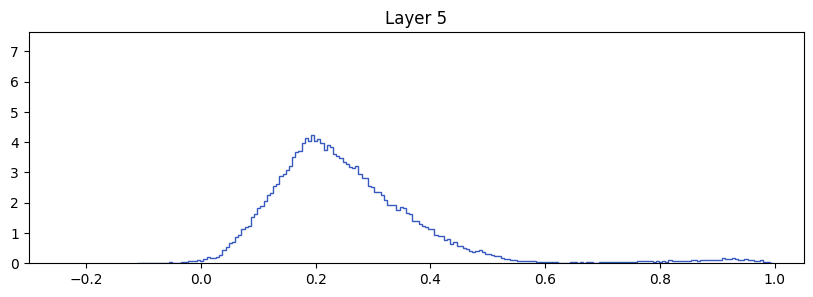

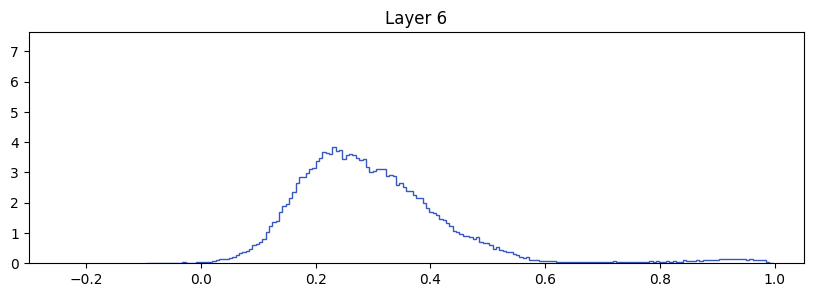

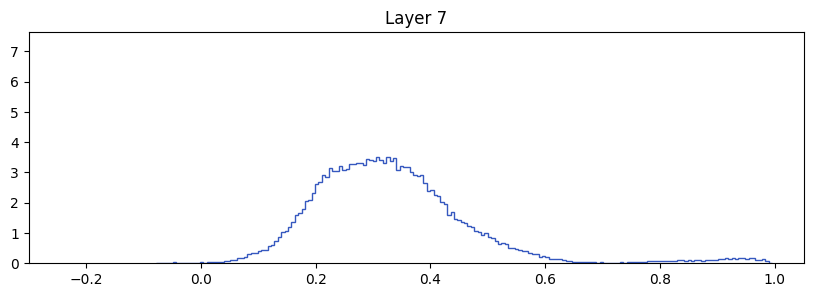

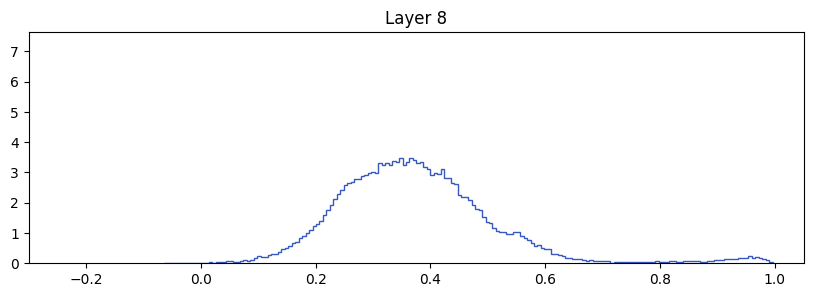

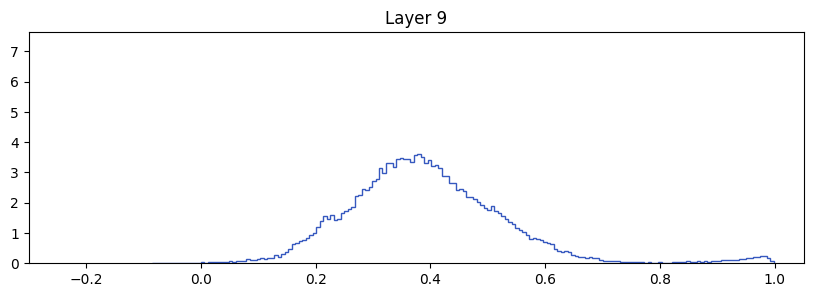

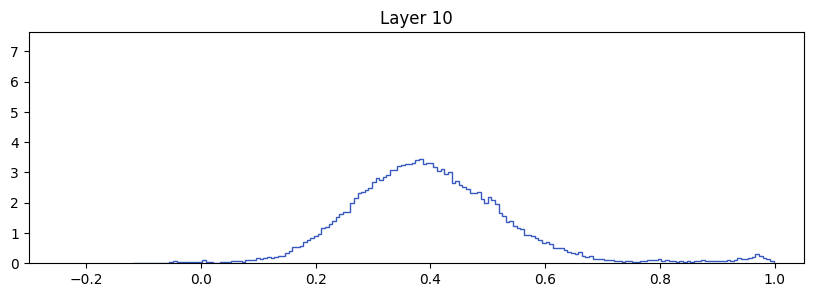

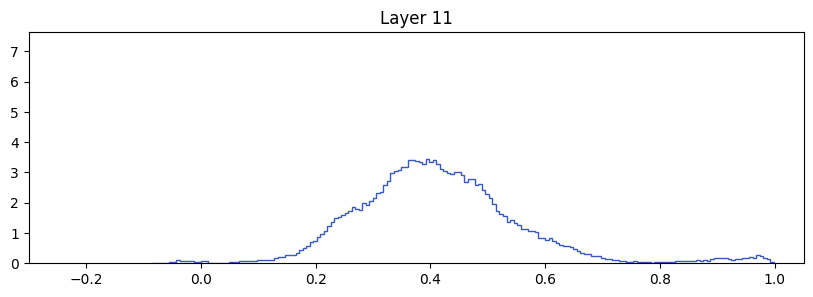

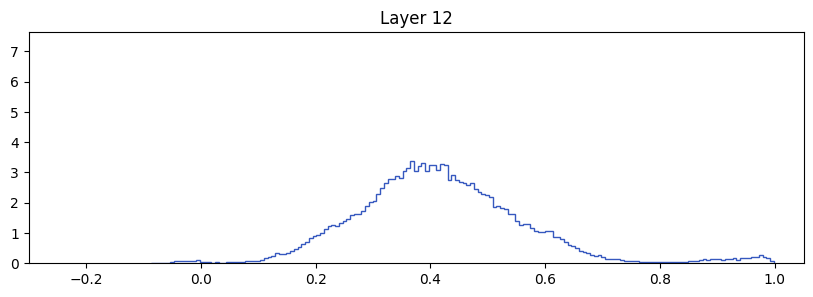

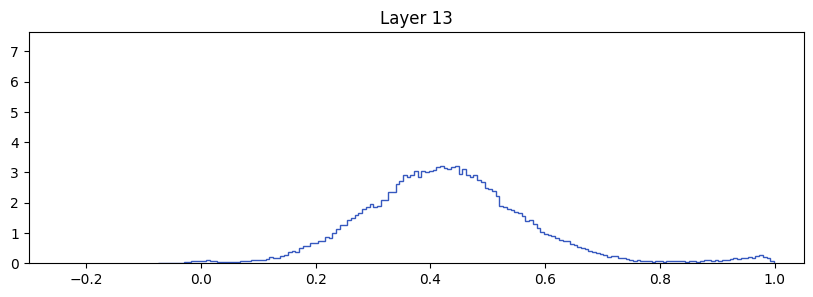

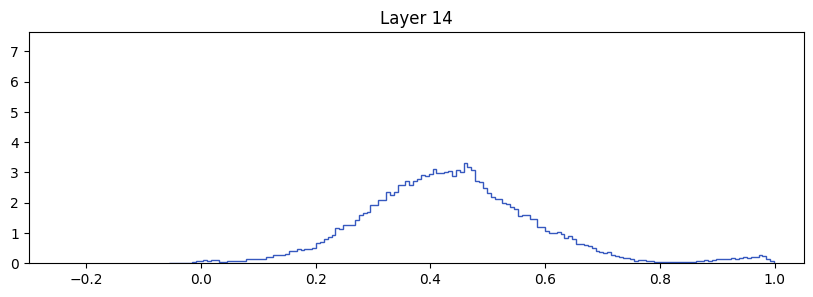

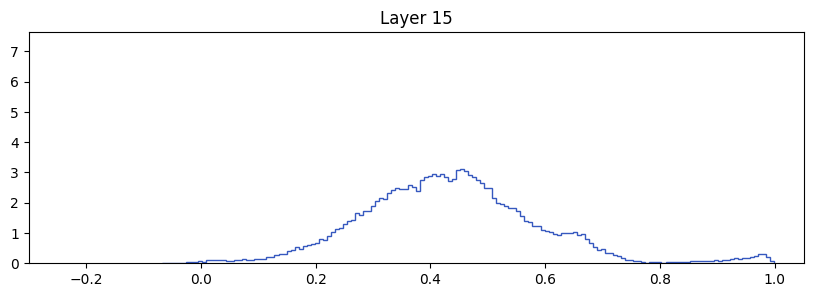

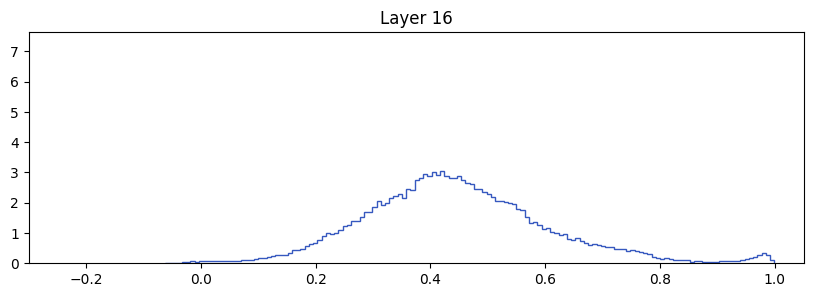

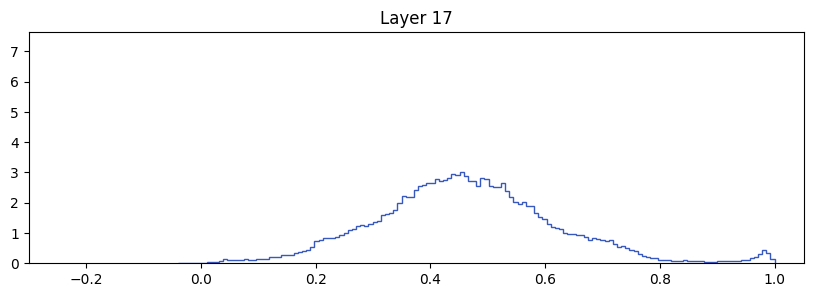

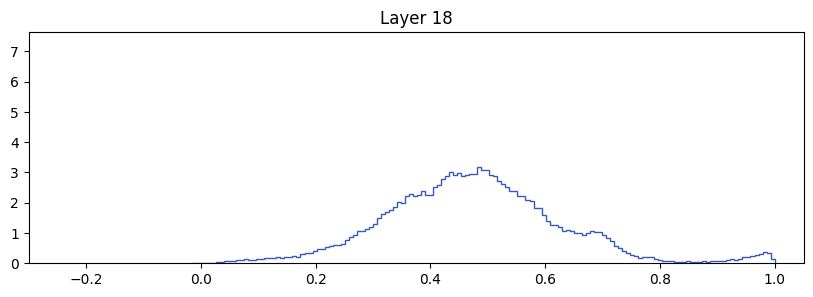

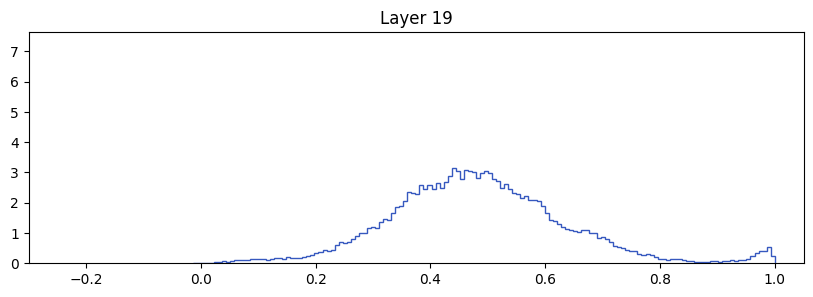

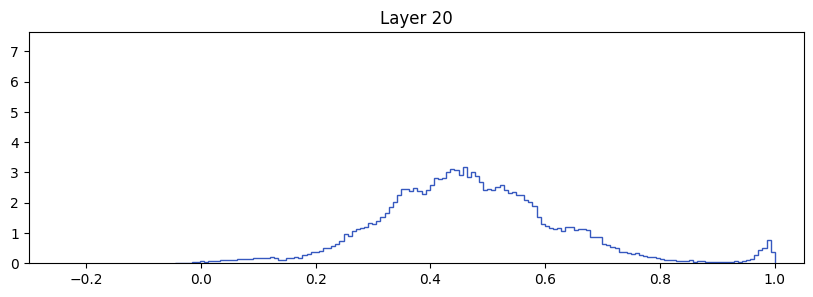

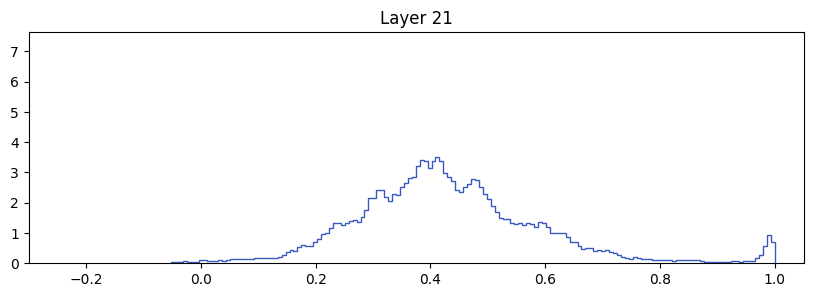

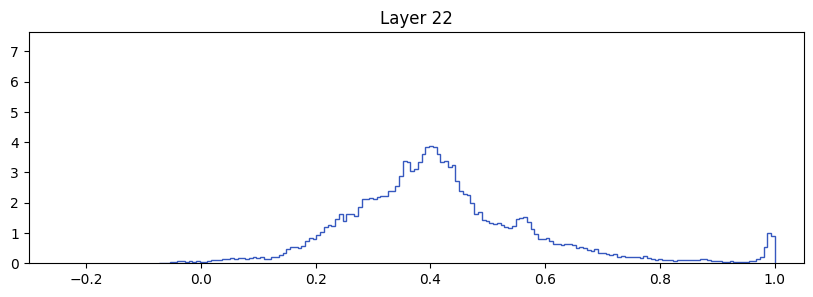

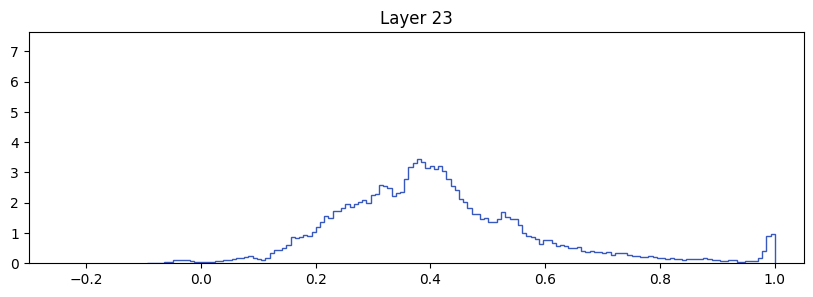

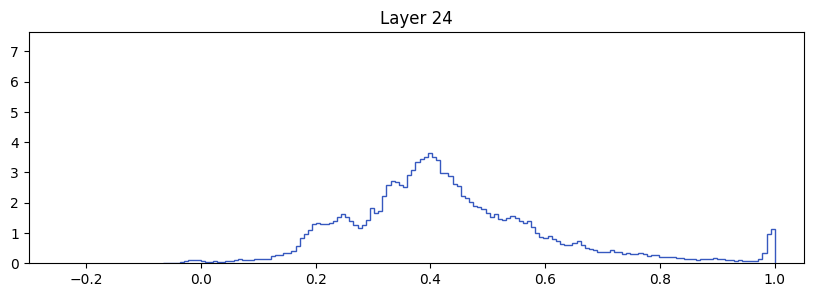

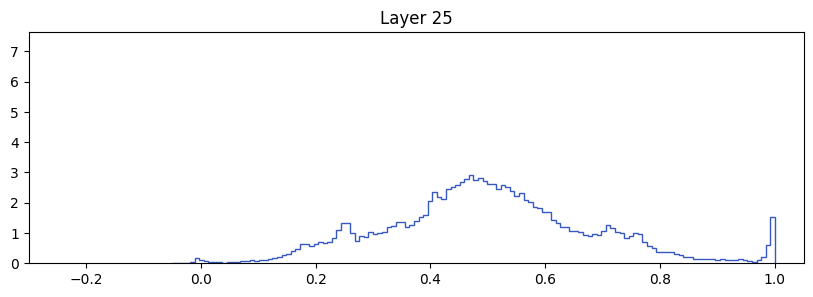

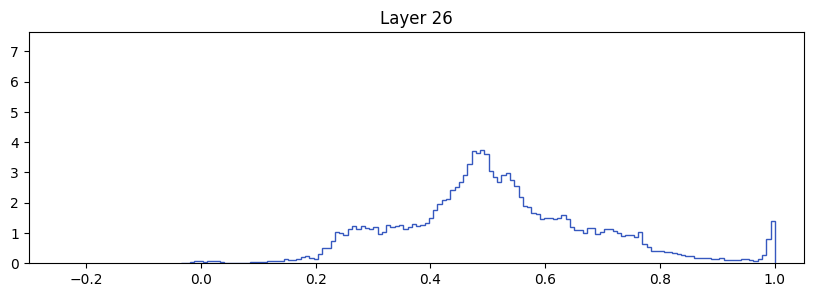

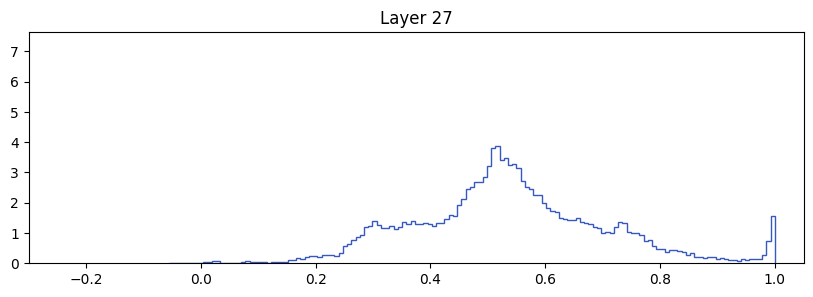

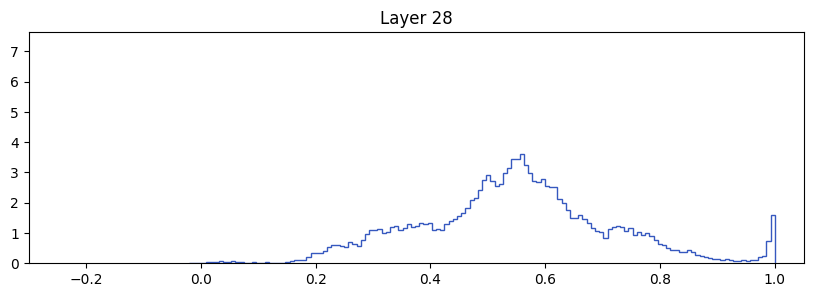

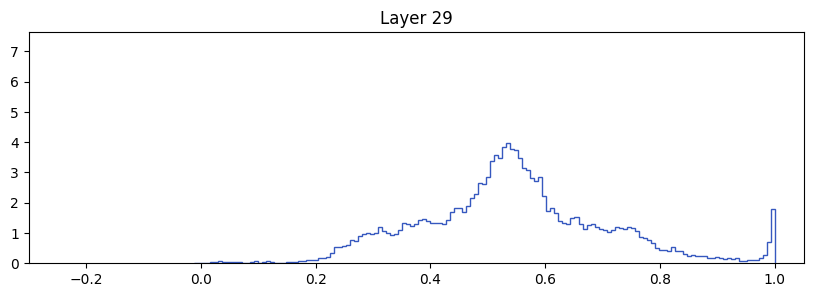

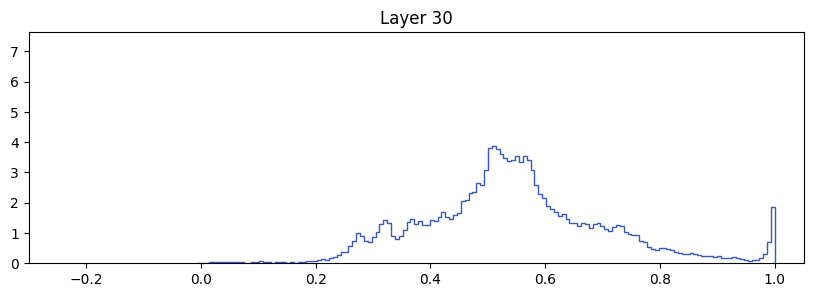

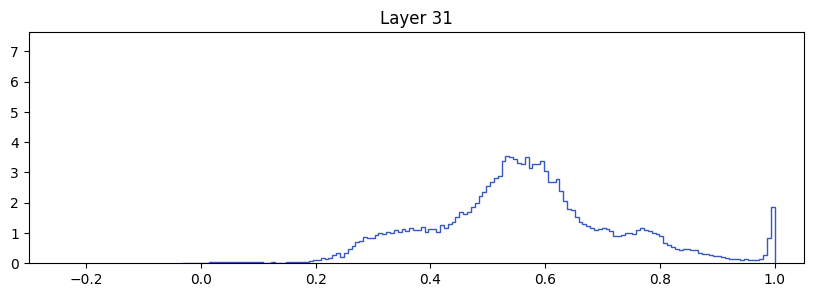

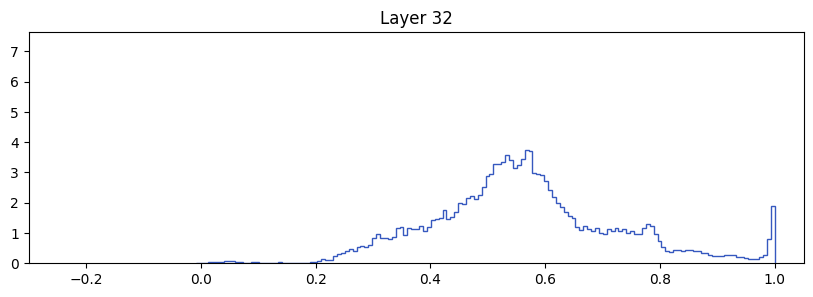

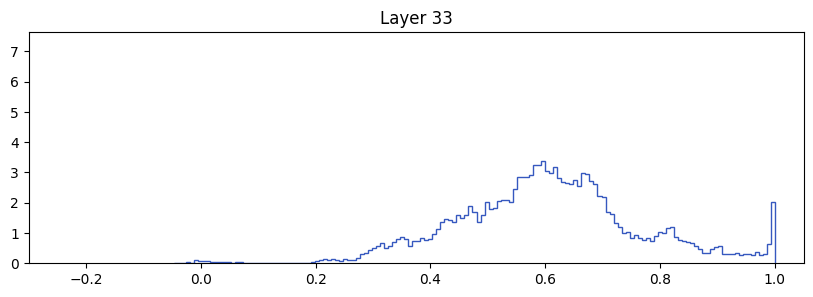

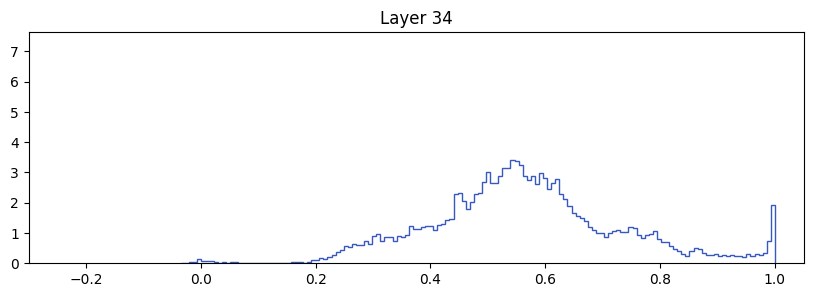

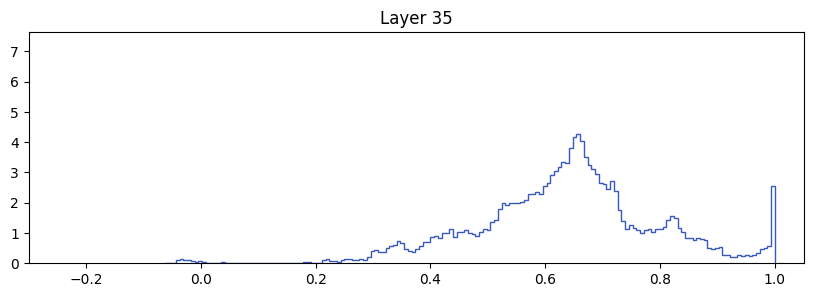

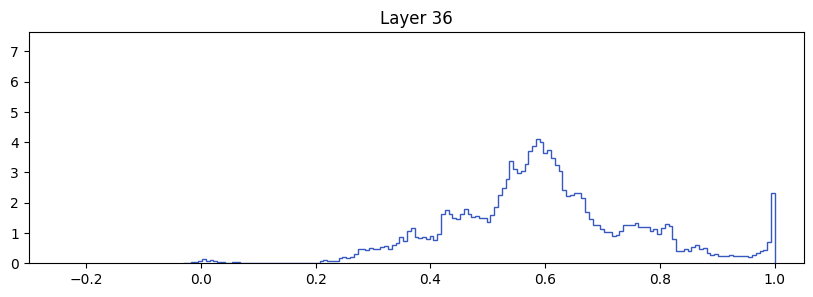

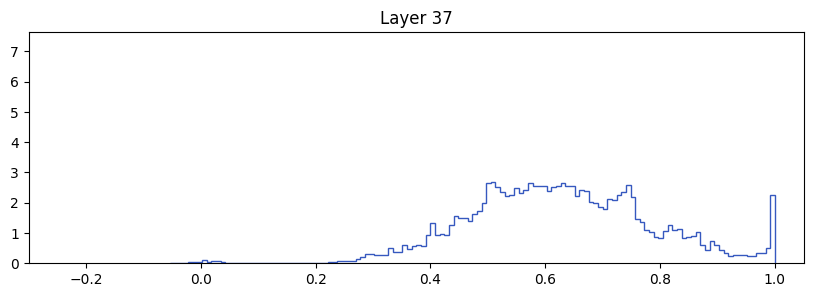

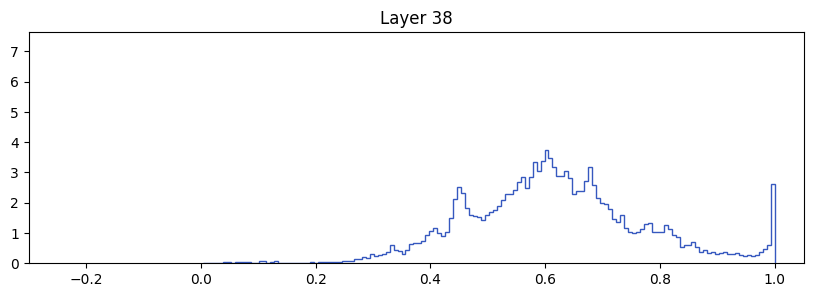

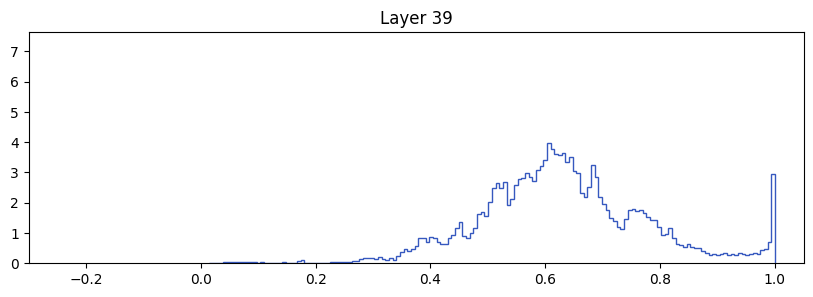

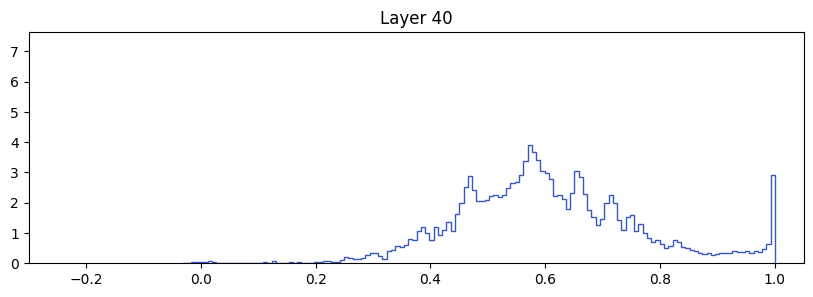

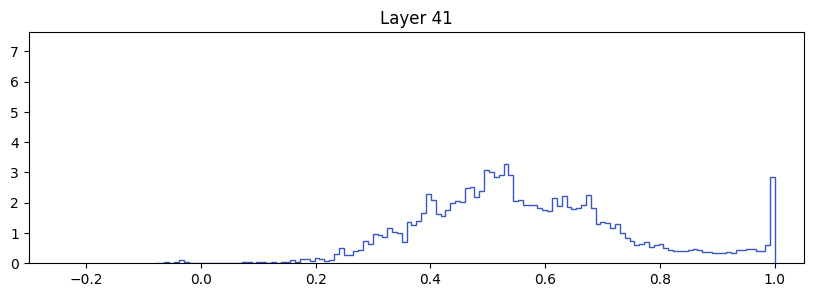

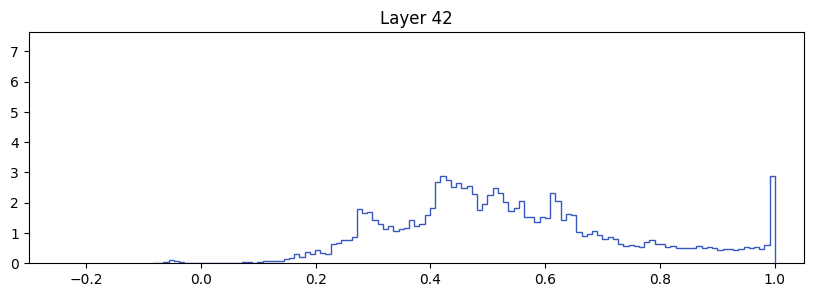

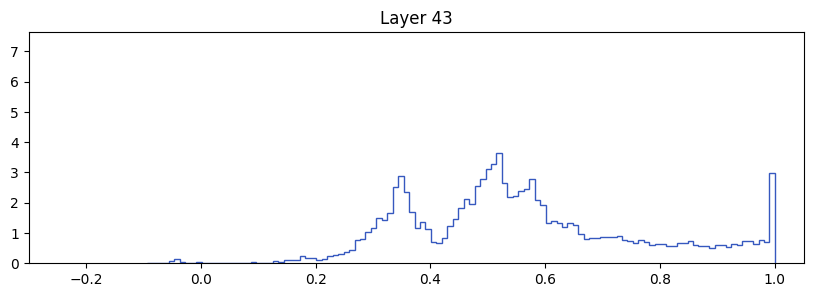

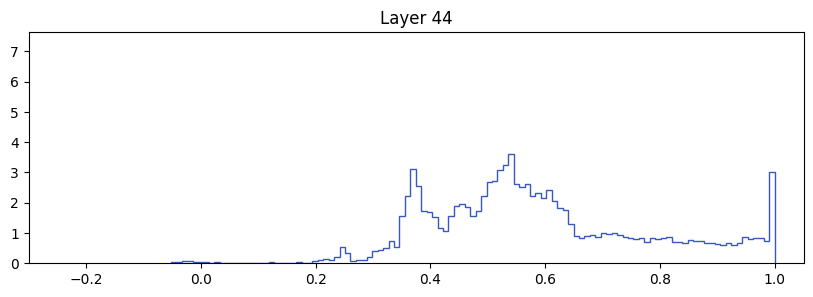

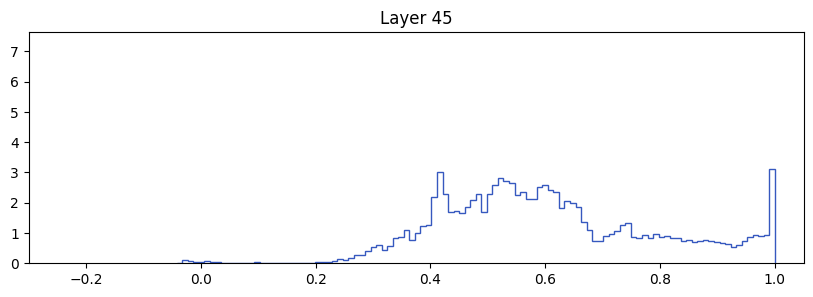

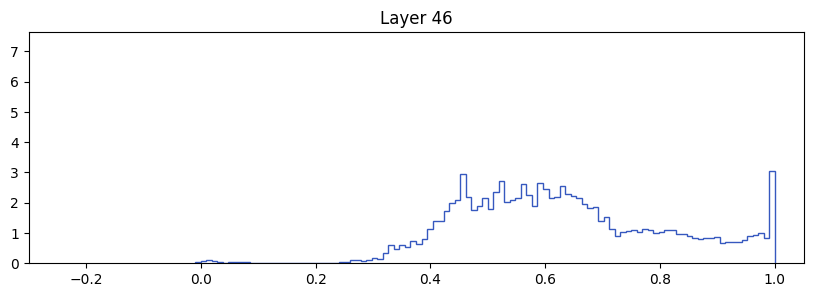

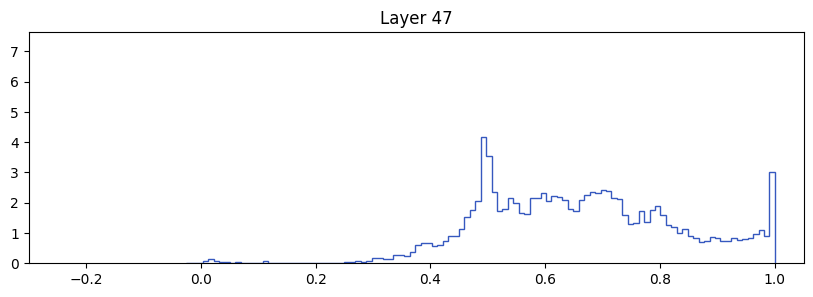

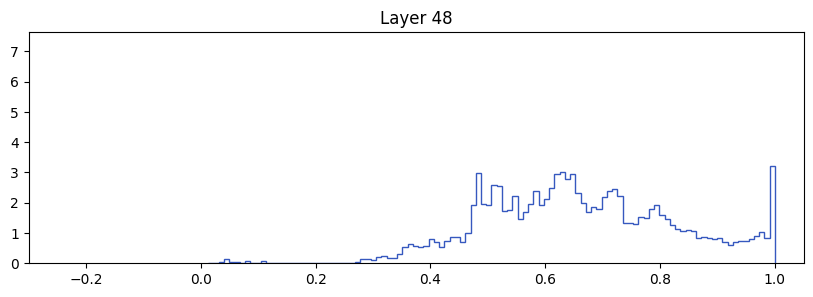

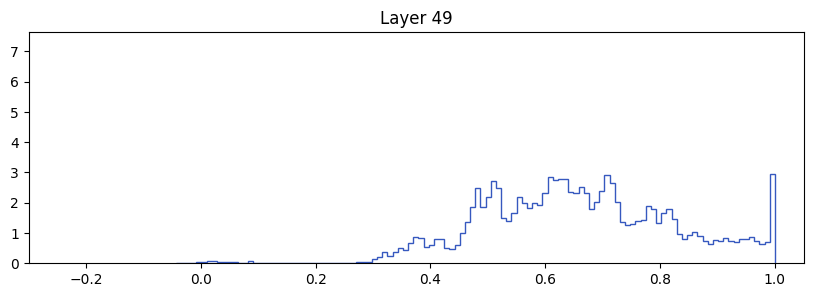

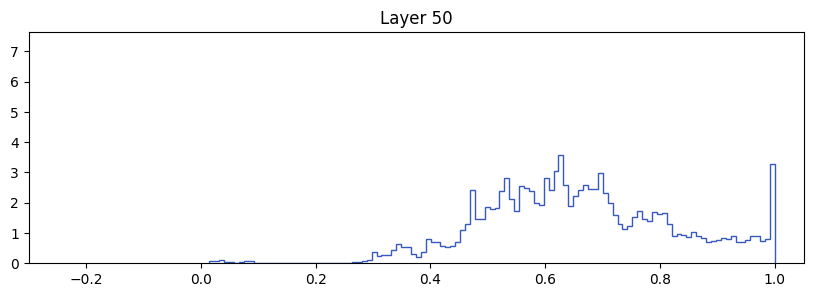

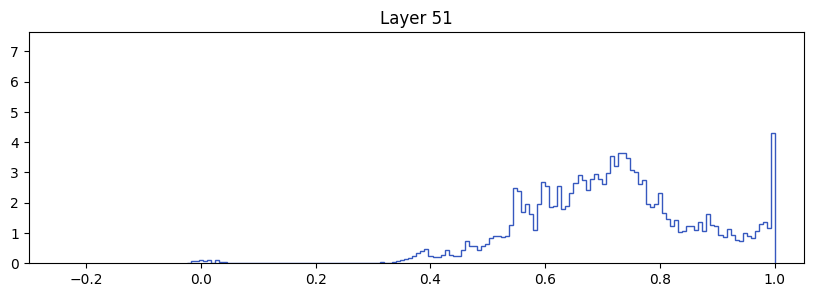

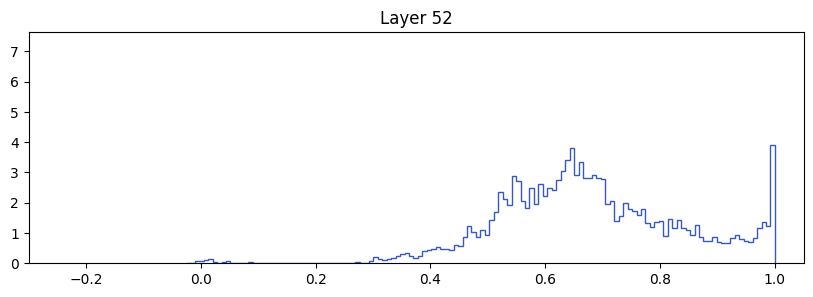

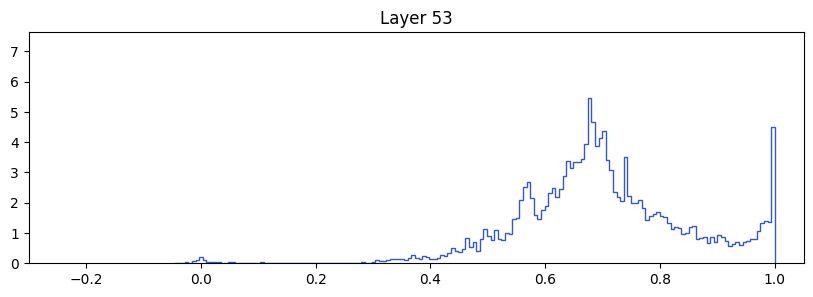

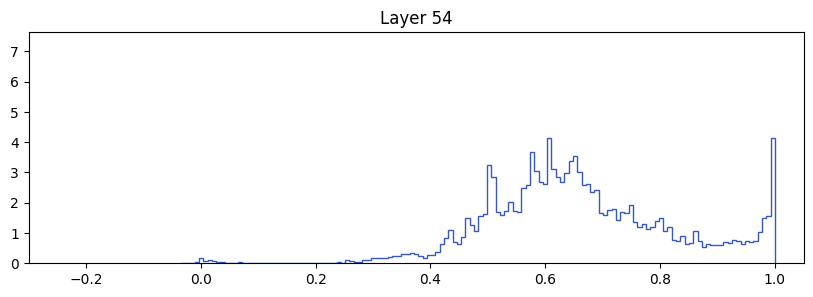

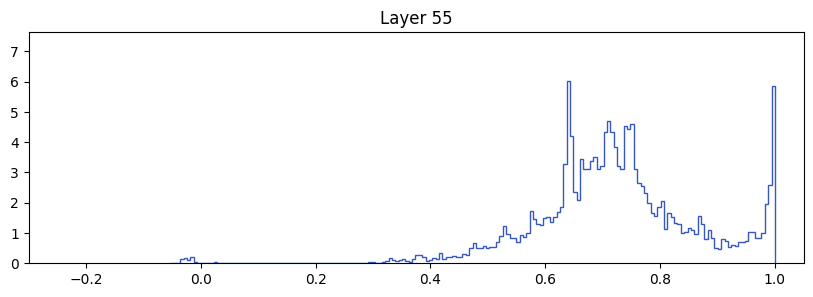

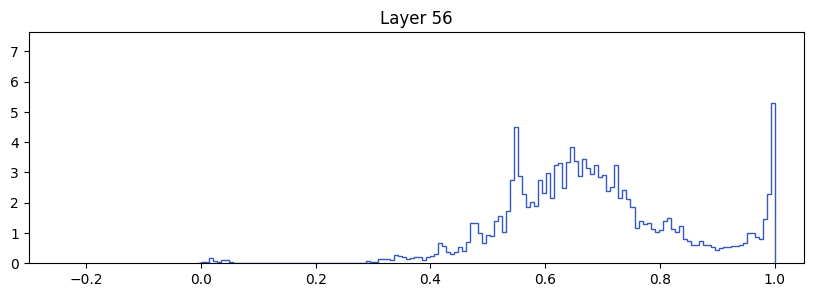

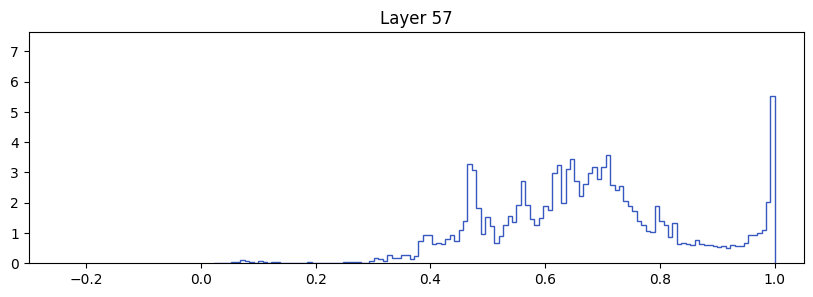

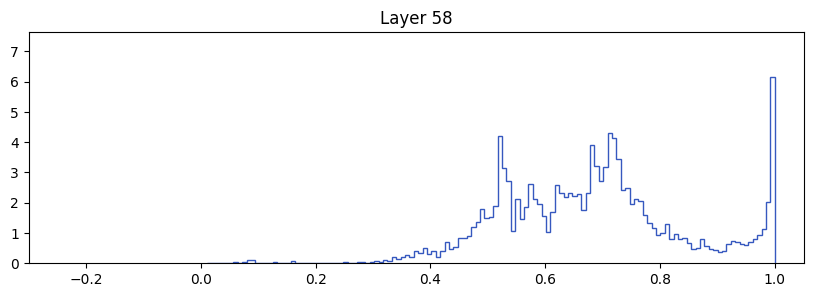

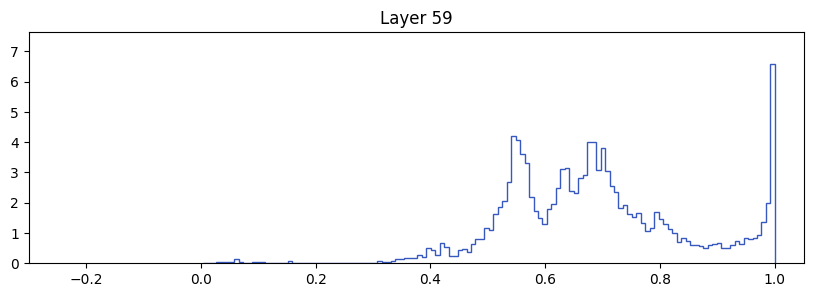

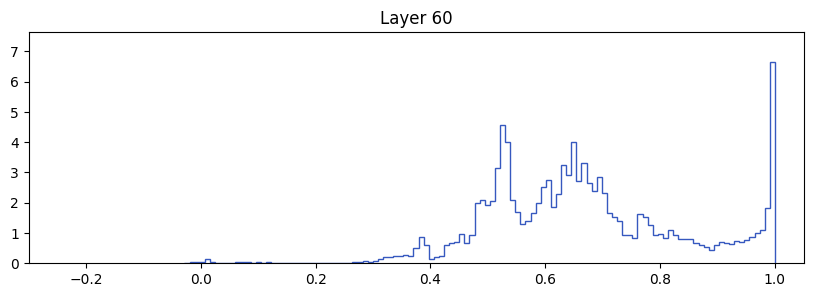

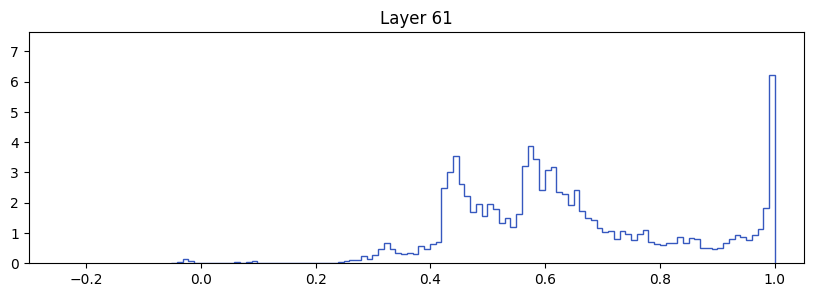

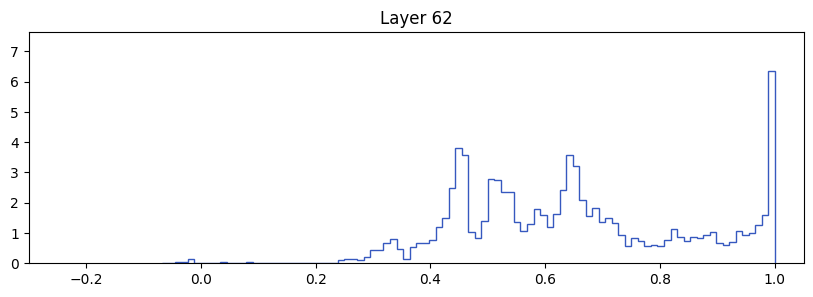

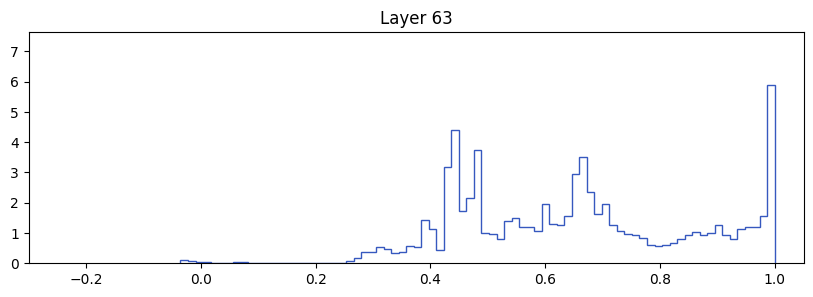

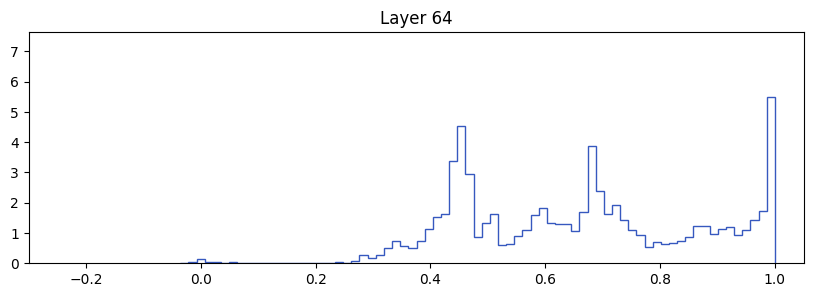

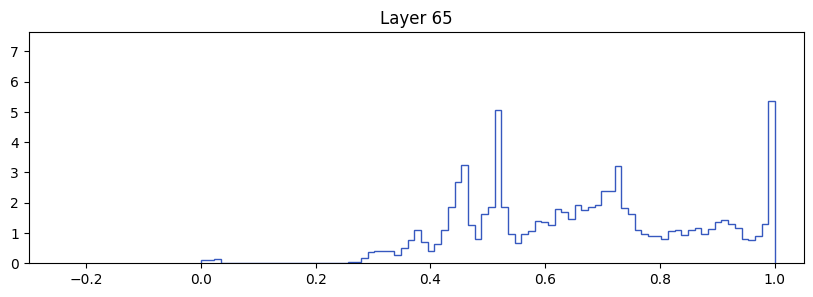

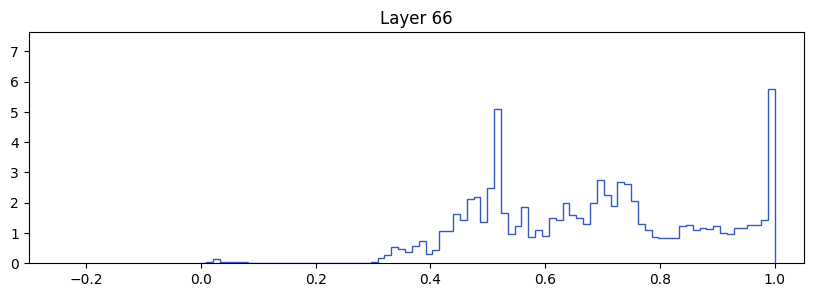

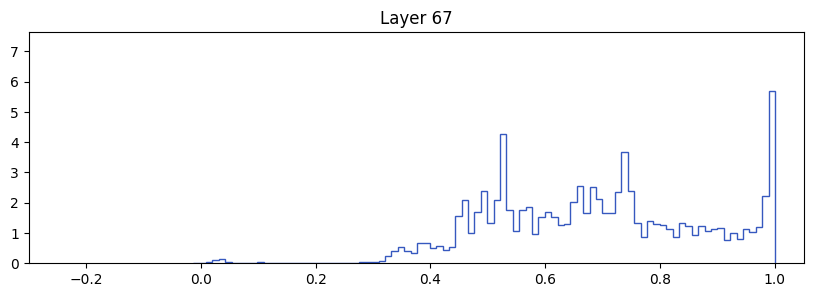

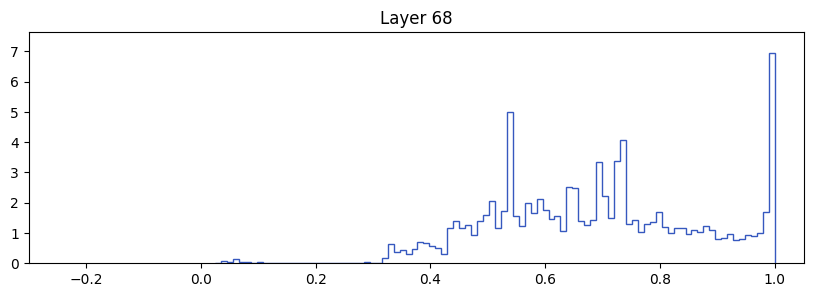

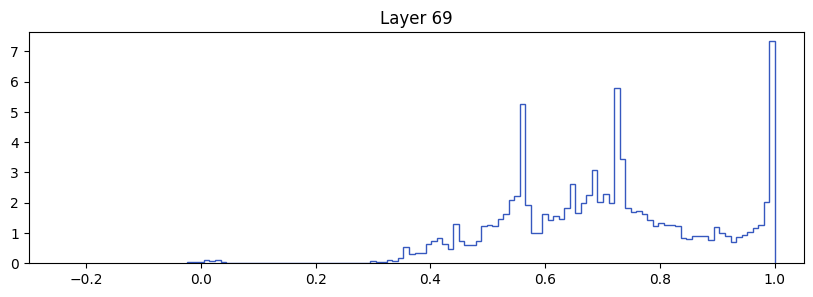

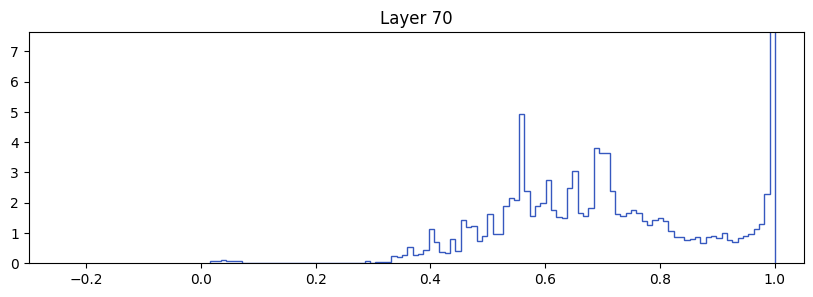

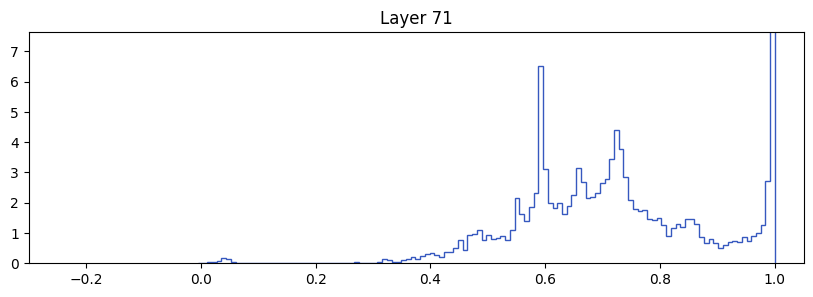

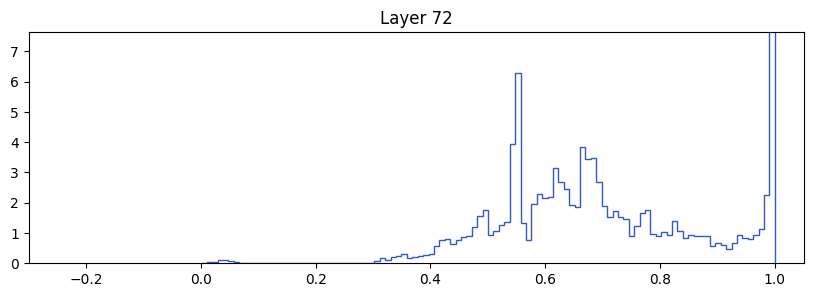

In [144]:
# Create and save individual histogram plots for each layer's token correlations.
# Use adaptive binning based on data distribution and consistent x,y-axis scaling across all plots.

# determine global max density (y) value
max_density = 0
for data in correls:
    counts, bin_edges = np.histogram(data, bins=100, density=True)
    max_density = max(max_density, max(counts))

for i, data in enumerate(correls):
    IQR = np.percentile(data, 75) - np.percentile(data, 25)
    n = len(data)
    bin_width = 2 * IQR / n ** (1 / 3)
    bins = int((max(data) - min(data)) / bin_width)

    plt.figure(figsize=(10, 3))
    plt.hist(
        data,
        bins=bins,
        density=True,
        histtype="step",
        color="#3658bf",
        linewidth=1,
    )
    plt.title(f"Layer {i}", fontsize=12)
    plt.xlim(-0.3, 1.05)
    plt.ylim(0, max_density)
    plt.savefig(f"{output_path}/histogram_layer_{i}.pdf")
    plt.show()
    plt.close()